In [1]:
import numpy as np
import torch as th
import torch.nn as nn
import torch.nn.functional as F

### Attention Mechanism
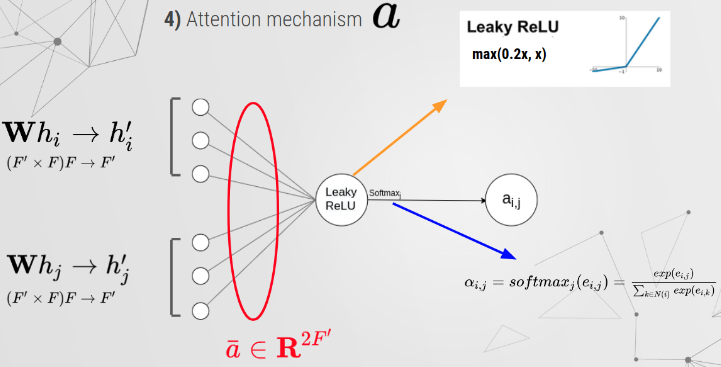

In [13]:
in_features = 5
out_features = 2
nb_nodes = 3


W = nn.Parameter(
    th.zeros(size=(in_features, out_features))
)  # xavier paramiter inizializator

a = nn.Parameter(th.zeros(2 * out_features, 1))
nn.init.xavier_uniform_(W.data, gain=1.414)
nn.init.xavier_normal_(a.data, gain=1.414)

x = th.rand(nb_nodes, in_features)

In [21]:
h = x @ W
N = h.size()[0]
print(h)

tensor([[-0.8666, -1.0046],
        [-1.3091, -1.3589],
        [-1.7142, -1.3688]], grad_fn=<MmBackward0>)


In [29]:
a_input = th.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(
    N, -1, 2 * out_features
)
a_input.shape

torch.Size([3, 3, 4])

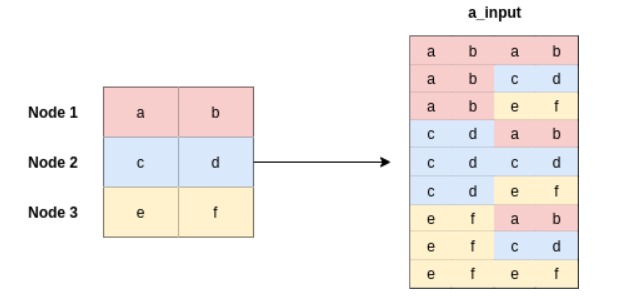
.view(N,-1,out_features)，相当于给N个节点分配了(-1,out_features)的输入，这里是(3,1)


In [68]:
e = F.leaky_relu(a_input @ a, negative_slope=0.2)
print(e.shape)
print(e, "\n")
print("e是(3,1)，squeeze为(3,)")
print(e.squeeze(2).shape)
e = e.squeeze(2)

torch.Size([3, 3, 1])
tensor([[[2.3259],
         [3.0225],
         [3.3830]],

        [[2.5691],
         [3.2657],
         [3.6262]],

        [[2.5778],
         [3.2743],
         [3.6348]]], grad_fn=<LeakyReluBackward0>) 

e是(3,1)，squeeze为(3,)
torch.Size([3, 3])


e是（N,N）矩阵，$e_{ij}$表示节点ij的e

In [74]:
print(e)

tensor([[2.3259, 3.0225, 3.3830],
        [2.5691, 3.2657, 3.6262],
        [2.5778, 3.2743, 3.6348]], grad_fn=<SqueezeBackward1>)


### Masked Attention

where(condition, input, other, *, out=None) -> Tensor

Return a tensor of elements selected from either :attr:`input` or :attr:`other`, depending on :attr:`condition`.

The operation is defined as:

$$
    \text{out}_i = \begin{cases}
        \text{input}_i & \text{if } \text{condition}_i \\
        \text{other}_i & \text{otherwise} \\
    \end{cases}
$$

这里设置zero_vec=-9e15是为了，softmax输出是0，如果是这里设置zero_vec=0的话softmax输出反而是正数

In [102]:
adj = th.randint(2, (3, 3))
zero_vec = -9e15 * th.ones_like(e)

# th.where(adj>0,e,zero_vec)
attention = th.where(adj > 0, e, zero_vec)
print(attention)

tensor([[-9.0000e+15, -9.0000e+15, -9.0000e+15],
        [-9.0000e+15, -9.0000e+15,  3.6262e+00],
        [-9.0000e+15, -9.0000e+15, -9.0000e+15]], grad_fn=<WhereBackward0>)


In [103]:
attention = F.softmax(attention, dim=1)
print(attention)

tensor([[0.3333, 0.3333, 0.3333],
        [0.0000, 0.0000, 1.0000],
        [0.3333, 0.3333, 0.3333]], grad_fn=<SoftmaxBackward0>)


In [105]:
h_prime = attention @ h
print(h_prime)

tensor([[-1.2966, -1.2441],
        [-1.7142, -1.3688],
        [-1.2966, -1.2441]], grad_fn=<MmBackward0>)


# Build the layer
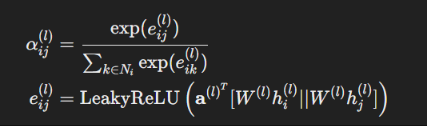

In [37]:
class GATLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GATLayer, self).__init__()
        self.W = nn.Parameter(th.rand(in_feats, out_feats))
        nn.init.xavier_uniform_(self.W.data, 1.414)

        self.a = nn.Parameter(th.rand(2 * out_feats, 1))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

        self.leakyrelu = nn.LeakyReLU()
        self.in_feats = in_feats
        self.out_feats = out_feats

    def forward(self, h_input, adj):
        h = th.matmul(h_input, self.W)

        N = h.size()[0]
        # Attention Mechanism
        a_input = th.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(
            N, -1, 2 * self.out_feats
        )
        # a_input [N,N,out_feats*2]
        # a [out_feats*2,1]
        # a_input@a [N,N,1]
        e = self.leakyrelu(th.matmul(a_input, self.a).squeeze(2))
        # e [N,N]
        # Masked Attention
        zero_vec = -9e15 * th.ones_like(e)
        attention = th.where(adj > 0, e, zero_vec)
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, training=self.training).view(N, N)
        h_output = attention @ h
        return h_output


# class GATLayer(nn.Module):
#     def __init__(self, in_features, out_features, dropout=0.6, alpha=0.2, concat=True):
#         super(GATLayer, self).__init__()
#         self.dropout = dropout  # drop prob = 0.6
#         self.in_features = in_features  #
#         self.out_features = out_features  #
#         self.alpha = alpha  # LeakyReLU with negative input slope, alpha = 0.2
#         self.concat = concat  # conacat = True for all layers except the output layer.

#         # Xavier Initialization of Weights
#         # Alternatively use weights_init to apply weights of choice
#         self.W = nn.Parameter(th.zeros(size=(in_features, out_features)))
#         nn.init.xavier_uniform_(self.W.data, gain=1.414)

#         self.a = nn.Parameter(th.zeros(size=(2 * out_features, 1)))
#         nn.init.xavier_uniform_(self.a.data, gain=1.414)

#         # LeakyReLU
#         self.leakyrelu = nn.LeakyReLU(self.alpha)

#     def forward(self, input, adj):
#         # Linear Transformation
#         h = th.mm(input, self.W)  # matrix multiplication
#         N = h.size()[0]

#         # Attention Mechanism
#         a_input = th.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(
#             N, -1, 2 * self.out_features
#         )
#         e = self.leakyrelu(th.matmul(a_input, self.a).squeeze(2))

#         # Masked Attention
#         zero_vec = -9e15 * th.ones_like(e)
#         attention = th.where(adj > 0, e, zero_vec)

#         attention = F.softmax(attention, dim=1)
#         attention = F.dropout(attention, self.dropout, training=self.training).view(N,-1)
#         h_prime = th.matmul(attention, h)

#         if self.concat:
#             return F.elu(h_prime)
#         else:
#             return h_prime

# Use it

In [38]:
import torch_geometric.transforms as T
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GATConv
from torch_geometric.utils import to_dense_adj

In [39]:
name_data = "Cora"
dataset = Planetoid(
    root="./data/Planetoid/", name="Cora", transform=T.NormalizeFeatures()
)
print(f"Number of Classes in {name_data}:", dataset.num_classes)
print(f"Number of Node Features in {name_data}:", dataset.num_node_features)

Number of Classes in Cora: 7
Number of Node Features in Cora: 1433


In [40]:
in_feats = dataset.num_features
out_feats = dataset.num_classes
data = dataset[0]

In [41]:
class GAT(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GAT, self).__init__()
        self.hid = 8
        self.conv1 = GATLayer(in_feats, self.hid)
        self.conv2 = GATLayer(self.hid, out_feats)
        # self.conv1 = GATConv(in_feats, self.hid)
        # self.conv2 = GATConv(self.hid, out_feats)

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        adj = to_dense_adj(edge_index)
        x = F.dropout(x, training=self.training)
        x = self.conv1(x, adj)
        # x=self.conv1(x,edge_index)

        x = F.elu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, adj)
        # x=self.conv2(x,edge_index)

        return F.softmax(x, dim=1)

# model = GAT(in_feats, out_feats)

In [42]:
device = "cuda"
th.cuda.empty_cache()
model = GAT(in_feats, out_feats).to(device)
data = data.to(device)
optimizer = th.optim.Adam(model.parameters(), lr=0.01)
criterion = th.nn.CrossEntropyLoss()

In [43]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()


def test():
    model.eval()
    with th.no_grad():
        pred = model(data).argmax(1)
        accs = []
        for mask in [data.train_mask, data.val_mask, data.test_mask]:
            correct = pred[mask] == data.y[mask]
            accs.append((correct.sum() / mask.sum()).item())
        return accs

In [45]:
for epoch in range(1, 201):
    loss = train()
    train_acc, val_acc, test_acc = test()
    if epoch % 10 == 0:
        print(
            f"Epoch: {epoch:03d}, loss: {loss:.6f}, Train: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}"
        )

Epoch: 010, loss: 1.799721, Train: 0.9000, Val Acc: 0.6640, Test Acc: 0.6810
Epoch: 020, loss: 1.784960, Train: 0.9071, Val Acc: 0.6780, Test Acc: 0.6950
Epoch: 030, loss: 1.758078, Train: 0.9429, Val Acc: 0.6980, Test Acc: 0.7250
Epoch: 040, loss: 1.729969, Train: 0.9429, Val Acc: 0.7160, Test Acc: 0.7360
Epoch: 050, loss: 1.707344, Train: 0.9571, Val Acc: 0.7180, Test Acc: 0.7470
Epoch: 060, loss: 1.722700, Train: 0.9571, Val Acc: 0.7380, Test Acc: 0.7560
Epoch: 070, loss: 1.675101, Train: 0.9571, Val Acc: 0.7580, Test Acc: 0.7590
Epoch: 080, loss: 1.641601, Train: 0.9643, Val Acc: 0.7680, Test Acc: 0.7660
Epoch: 090, loss: 1.609452, Train: 0.9571, Val Acc: 0.7680, Test Acc: 0.7770
Epoch: 100, loss: 1.609796, Train: 0.9571, Val Acc: 0.7680, Test Acc: 0.7800
Epoch: 110, loss: 1.627059, Train: 0.9643, Val Acc: 0.7660, Test Acc: 0.7860
Epoch: 120, loss: 1.623179, Train: 0.9643, Val Acc: 0.7720, Test Acc: 0.7910
Epoch: 130, loss: 1.607377, Train: 0.9714, Val Acc: 0.7700, Test Acc: 0.7870